In [ ]:
#Create logistic regression model to compare to CNN

#Used the following notebook as resource: https://www.kaggle.com/gulsahdemiryurek/image-classification-with-logistic-regression

#get data from google drive:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
#imports below:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2 
import os 
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, confusion_matrix, precision_score, ConfusionMatrixDisplay

import matplotlib.image as img

In [ ]:
train_data_dir = '/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/Training100x100v2' #change to Training100x100v2
testing_data_dir = '/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/Testing100x100v2'
#nb_train_samples = 2526
#nb_validation_samples = 510


training_data = os.listdir(train_data_dir)
testing_data = os.listdir(testing_data_dir)

In [ ]:
def train_data():
    #we want to read the csv and label each image as benign or malignant

    train_data_benign = [] 
    train_data_malignant=[]

    training_table = pd.read_csv(r'/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/train samplev2.csv') # train samplev2.csv

    for index, row in training_table.iterrows():
      if(row['target'] == 0):
        #append image to train_data_benign
        img_path = os.path.join(train_data_dir, row['img_name'])
        image = img.imread(img_path)
        train_data_benign.append(image)
      else:
        #append to train_data_malignant
        img_path = os.path.join(train_data_dir, row['img_name'])
        image = img.imread(img_path)
        train_data_malignant.append(image)

    print("The number of images in train_data_benign: "+str(len(train_data_benign)))
    print("The number of images in train_data_malignant: "+str(len(train_data_malignant)))
    train_data= np.concatenate((np.asarray(train_data_benign),np.asarray(train_data_malignant)),axis=0)
    return train_data 

In [ ]:
def test_data():

    test_data_benign = [] 
    test_data_malignant=[]
    testing_table = pd.read_csv(r'/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/test samplev2.csv') #test samplev2.csv

    for index, row in testing_table.iterrows():
      if(row['target'] == 0):
        #append image to test_data_benign
        img_path = os.path.join(testing_data_dir, row['img_name'])
        image = img.imread(img_path)
        test_data_benign.append(image)
      else:
        #append to test_data_malignant
        img_path = os.path.join(testing_data_dir, row['img_name'])
        image = img.imread(img_path)
        test_data_malignant.append(image)
    
    print("The number of images in test_data_benign: "+str(len(test_data_benign)))
    print("The number of images in test_data_malignant: "+str(len(test_data_malignant)))
    test_data= np.concatenate((np.asarray(test_data_benign),np.asarray(test_data_malignant)),axis=0) 
    return test_data

In [ ]:
#train_data = train_data() 
#test_data = test_data()
x_train = train_data()
x_train = (x_train-np.min(x_train))/(np.max(x_train)-np.min(x_train))
x_test = test_data()
x_test = (x_test-np.min(x_test))/(np.max(x_test)-np.min(x_test))

The number of images in train_data_benign: 6006
The number of images in train_data_malignant: 1572
The number of images in test_data_benign: 1350
The number of images in test_data_malignant: 180


In [ ]:
z1 = np.zeros(6006) # plug in the correct number of training samples as parameter
o1 = np.ones(1572) # plug in the correct number of training samples as parameter
y_train = np.concatenate((o1, z1), axis=0)
z = np.zeros(1350) # plug in the correct number of testing samples as parameter
o = np.ones(180) # plug in the correct number of testing samples as parameter
y_test = np.concatenate((o, z), axis=0)


In [ ]:
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

x_train_flatten = x_train.reshape(number_of_train,-1) # x_train.shape[1]*x_train.shape[2]
x_test_flatten = x_test .reshape(number_of_test,-1) # x_test.shape[1]*x_test.shape[2]
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)

y_train_flatten = y_train.reshape(y_train.shape[0], -1)
y_test_flatten = y_test.reshape(y_test.shape[0], -1)
print("Y train flatten",y_train_flatten.shape)
print("Y test flatten",y_test_flatten.shape)

X train flatten (7578, 30000)
X test flatten (1530, 30000)
Y train flatten (7578, 1)
Y test flatten (1530, 1)


In [ ]:
x_train = x_train_flatten.T
x_test = x_test_flatten.T
y_test = y_test_flatten.T
y_train = y_train_flatten.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (30000, 7578)
x test:  (30000, 1530)
y train:  (1, 7578)
y test:  (1, 1530)


In [ ]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients
#maybe try lowering the learning rate? The learning steps might be too big
def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))

    return y_prediction_test

Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: 0.756488
Cost after iteration 300: 0.722010
Cost after iteration 400: 0.698590
Cost after iteration 500: 0.676768
Cost after iteration 600: 0.656598
Cost after iteration 700: 0.638115
Cost after iteration 800: 0.621324
Cost after iteration 900: 0.606206
Cost after iteration 1000: 0.592711
Cost after iteration 1100: 0.580762
Cost after iteration 1200: 0.570261
Cost after iteration 1300: 0.561092
Cost after iteration 1400: 0.553129


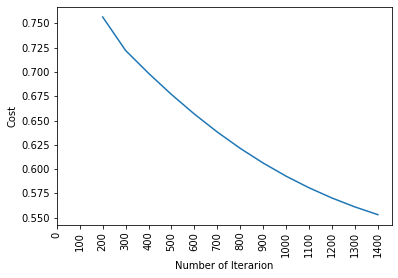

Test Accuracy: 86.99 %
Train Accuracy: 77.57 %


In [ ]:
y_pred = logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.0001, num_iterations = 1500) #CHANGE the learning_rate to 0.001 and 0.0001 and see what happens

PPV |  [0.88239203 0.12      ]  Recall |  [0.9837037  0.01666667]


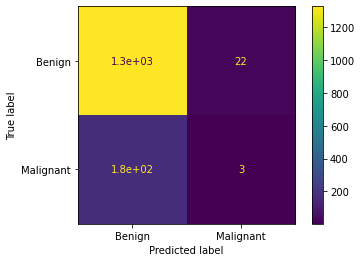

In [ ]:
y_test_list = []
y_pred_list = []
for tumor_list in y_test:
  for tumor in tumor_list:
    if tumor == 1.0:
      y_test_list.append(1.0)
    else:
      y_test_list.append(0.0)
for tumor_list in y_pred:
  for tumor in tumor_list:
    if tumor == 1.0:
      y_pred_list.append(1.0)
    else:
      y_pred_list.append(0.0)
#confusion_matrix(y_test_list, y_pred_list)

#look at precision and recall
ppv = precision_score(y_test_list, y_pred_list, average=None)
recall = recall_score(y_test_list, y_pred_list, average=None)
print("PPV | ",ppv," Recall | ",recall)


#nice confusion matrix

class_names = np.array(['Benign', 'Malignant'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_list, y_pred_list),
                              display_labels=class_names)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal') #Each of these are the default values

plt.show() #Can't get rid of the annoying color bar

In [ ]:
log_reg= LogisticRegression(C=1, penalty='l2', solver='lbfgs')
log_reg.fit(x_train.T,y_train.T)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:

print("test accuracy: {} ".format(accuracy_score(y_test.T, log_reg.predict(x_test.T))))
print("train accuracy: {} ".format(accuracy_score(y_train.T, log_reg.predict(x_train.T))))
cf_matrix = confusion_matrix(y_test_list, log_reg.predict(x_test.T))

test accuracy: 0.8379084967320262 
train accuracy: 0.8120876220638691 


PPV |  [0.89189189 0.22580645]  Recall |  [0.92888889 0.15555556]


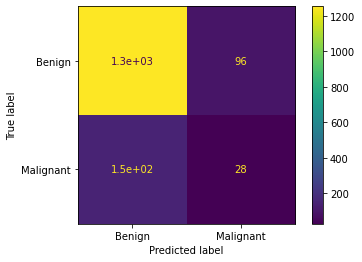

In [ ]:

ppv = precision_score(y_test_list, log_reg.predict(x_test.T), average=None)
recall = recall_score(y_test_list, log_reg.predict(x_test.T), average=None)
print("PPV | ",ppv," Recall | ",recall)


class_names = np.array(['Benign', 'Malignant'])
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=class_names)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal') #Each of these are the default values

plt.show() #Can't get rid of the annoying color bar

In [ ]:
grid={"C":np.logspace(-3,3,7),"penalty":["l1","l2"]},
logistic_regression_2=LogisticRegression(random_state=42)
log_reg_cv=GridSearchCV(logistic_regression_2,grid,cv=10)
log_reg_cv.fit(x_train.T,y_train.T)


print("best hyperparameters: ", log_reg_cv.best_params_)
print("accuracy: ", log_reg_cv.best_score_)